# HGPS


## HGPS

The **H.E.S.S. Galactic Plane Survey (HGPS)** is the first deep and wide survey of the Milky Way in TeV gamma-rays.

The release data consistes of 10 survey maps and several tables that contain a source catalog and other information.

The data is available here for download, in FITS format:
https://www.mpi-hd.mpg.de/hfm/HESS/hgps

**Please read the Appendix A of the paper to learn about the caveats to using the HGPS data. Especially note that the HGPS survey maps are correlated and thus no detailed source morphology analysis is possible, and also note the caveats concerning spectral models and spectral flux points.**

## Topics

This is a Jupyter notebook that illustrates how to work with the HGPS data from Python. You will learn how to access the HGPS images as well as the HGPS catalog and other tabular data using Astropy and Gammapy.

* In the first part we will only use Astropy to do some basic things.
* Then in the second part we'll use Gammapy to do some things that are a little more advanced.

Note that there are other tools to work with FITS data that we don't explain here. Specifically [DS9](http://ds9.si.edu/) and [Aladin](http://aladin.u-strasbg.fr/) are good FITS image viewers, and [TOPCAT](http://www.star.bris.ac.uk/~mbt/topcat/) is great for FITS tables. Astropy and Gammapy are just one way to work with the HGPS data; any tool that can access FITS data can be used.

## Packages

We will be using the following Python packages and features:

* [astropy](http://docs.astropy.org/), specifically [astropy.io.fits](http://docs.astropy.org/en/stable/io/fits/index.html) to read the FITS data, [astropy.table.Table](http://docs.astropy.org/en/stable/table/index.html) to work with the tables, but also [astropy.coordinates.SkyCoord](http://docs.astropy.org/en/stable/coordinates/index.html) and [astropy.wcs.WCS](http://docs.astropy.org/en/stable/wcs/index.html) to work with sky and pixel coordinates and [astropy.units.Quantity](http://docs.astropy.org/en/stable/units/index.html) to work with quantities.

* [regions](https://astropy-regions.readthedocs.io/) to show HGPS source spectral extraction circular regions and create corresponding DS9 regions.

* [gammapy](http://docs.gammapy.org/), specifically [gammapy.maps](http://docs.gammapy.org/dev/maps/index.html) to work with the HGPS sky maps, and [gammapy.catalog.SourceCatalogHGPS](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalogHGPS.html) and [gammapy.catalog.SourceCatalogObjectHGPS](http://docs.gammapy.org/dev/api/gammapy.catalog.SourceCatalogObjectHGPS.html) to work with the HGPS catalog data, especially the HGPS spectral data using [gammapy.spectrum.models.SpectralModel](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.SpectralModel.html) and [gammapy.spectrum.FluxPoints](http://docs.gammapy.org/dev/api/gammapy.spectrum.FluxPoints.html) objects.

* [matplotlib](https://matplotlib.org/) for plotting, used via [astropy.visualization](http://docs.astropy.org/en/stable/visualization/index.html) and [gammapy.maps.WcsNDMap.plot](http://docs.gammapy.org/dev/api/gammapy.maps.WcsNDMap.html#gammapy.maps.WcsNDMap.plot)
for sky map plotting.

If you're not familiar with Python, Numpy, Astropy, Gammapy or matplotlib yet, you can learn about them using the links to the documentation that we just mentioned, or using the tutorial introductions as explained [here](http://docs.gammapy.org/dev/tutorials.html).


## Setup

We start by importing everything we will use in this notebook, and configuring the notebook to show plots inline.
If you get an error here, you probably have to install the missing package and re-start the notebook.

In [1]:
import os

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
import regions

from gammapy.maps import Map
from gammapy.catalog import SourceCatalogHGPS

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Data

First, you need to download the HGPS FITS data from https://www.mpi-hd.mpg.de/hfm/HESS/hgps .

If you haven't already, you can use the following commands to download the files to your local working directory.

You don't have to read the code in the next cell; that's just how to downlaod files from Python.
You could also download the files with your web browser, or from the command line e.g. with curl:

    mkdir hgps_data
    cd hgps_data
    curl -O https://www.mpi-hd.mpg.de/hfm/HESS/hgps/data/hgps_catalog_v1.fits.gz
    curl -O https://www.mpi-hd.mpg.de/hfm/HESS/hgps/data/hgps_map_significance_0.1deg_v1.fits.gz

The rest of this notebook assumes that you have the data files at ``hgps_data_path``.

In [3]:
# Download HGPS data used in this tutorial to a folder of your choice
# The default `hgps_data` used here is a sub-folder in your current
# working directory (where you started the notebook)
hgps_data_path = 'hgps_data'    

# The Python standard library has a function to retrieve file
# from a given URL; it's just located in a different place
# in Python 3 and Python 2, so while Python 2 is still in use
# we put this to make it work in both versions
try:
    from urllib.request import urlretrieve
except:
    from urllib import urlretrieve

def hgps_data_download():
    base_url = 'https://www.mpi-hd.mpg.de/hfm/HESS/hgps/data/'
    filenames = [
        'hgps_catalog_v1.fits.gz',
        'hgps_map_significance_0.1deg_v1.fits.gz',
    ]
    
    if not os.path.exists(hgps_data_path):
        os.makedirs(hgps_data_path)
    
    for filename in filenames:
        url = base_url + filename
        path = os.path.join(hgps_data_path, filename)
        if os.path.exists(path):
            print('Already downloaded: {}'.format(path))
        else:
            print('Downloading {} to {}'.format(url, path))
            urlretrieve(url, path)

hgps_data_download()

print('\n\nFiles at {} :\n'.format(os.path.abspath(hgps_data_path)))
for filename in os.listdir(hgps_data_path):
    print(filename)

Already downloaded: hgps_data/hgps_catalog_v1.fits.gz
Already downloaded: hgps_data/hgps_map_significance_0.1deg_v1.fits.gz


Files at /Users/deil/code/gammapy-extra/notebooks/hgps_data :

hgps_map_significance_0.1deg_v1.fits.gz
hgps_catalog_v1.fits.gz


## Catalog with Astropy

tbd

In [4]:
filename = os.path.join(hgps_data_path, 'hgps_catalog_v1.fits.gz')
hdu_list = fits.open(filename)
hdu_list.info()

Filename: hgps_data/hgps_catalog_v1.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  HGPS_SOURCES    1 BinTableHDU    327   78R x 78C   [16A, 6A, 10A, 20A, 7A, E, E, E, E, E, E, E, E, K, 18A, 103A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, 40E, 40E, 40E, 40E, 40E, 40E, 40E, 40B]   
  2  HGPS_GAUSS_COMPONENTS    1 BinTableHDU     87   98R x 13C   [9A, 16A, 15A, E, E, E, E, E, E, E, E, E, E]   
  3  HGPS_ASSOCIATIONS    1 BinTableHDU     39   223R x 4C   [16A, 5A, 21A, E]   
  4  HGPS_IDENTIFICATIONS    1 BinTableHDU     53   31R x 9C   [16A, 17A, 9A, 11A, 21A, 21A, E, E, E]   
  5  HGPS_LARGE_SCALE_COMPONENT    1 BinTableHDU     55   50R x 7C   [E, E, E, E, E, E, E]   
  6  SNRCAT        1 BinTableHDU     56   282R x 7C   [11A, E, E, 29A, E, E, E]   


## Maps with Astropy

tbd

In [5]:
filename = os.path.join(hgps_data_path, 'hgps_map_significance_0.1deg_v1.fits.gz')
hdu_list = fits.open(filename)
hdu_list.info()
hdu = hdu_list[0]

Filename: hgps_data/hgps_map_significance_0.1deg_v1.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Significance    1 PrimaryHDU      30   (9400, 500)   float32   


In [6]:
type(hdu.data)

numpy.ndarray

In [7]:
hdu.data.shape

(500, 9400)

In [8]:
hdu.data.max()

89.49691

In [9]:
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 9400                                                  
NAXIS2  =                  500                                                  
EXTNAME = 'Significance'                                                        
HDUNAME = 'Significance'                                                        
CTYPE1  = 'GLON-CAR'           / Type of co-ordinate on axis 1                  
CTYPE2  = 'GLAT-CAR'           / Type of co-ordinate on axis 2                  
EQUINOX =                2000. / [yr] Epoch of reference equinox                
CRPIX1  =               4700.5 / Reference pixel on axis 1                      
CRPIX2  =                250.5 / Reference pixel on axis 2                      
CRVAL1  =                  3

In [10]:
wcs = WCS(hdu.header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR'  'GLAT-CAR'  
CRVAL : 341.0  0.0  
CRPIX : 4700.5  250.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.02  0.02  
NAXIS : 9400  500

In [11]:
pos = SkyCoord(0, 0, unit='deg', frame='galactic')
pos.to_pixel(wcs)

(array(3749.5), array(249.5))

## Convert catalog format

The HGPS catalog is only released in FITS format.

This section shows you how you can convert part of the information to the following commonly used formats:

* CSV
* DS9 regions

tbd

## Catalog with Gammapy

tbd

In [12]:
filename = os.path.join(hgps_data_path, 'hgps_catalog_v1.fits.gz')
cat = SourceCatalogHGPS(filename)

In [13]:
source = cat[0]

In [14]:
print(source)


*** Basic info ***

Catalog row index (zero-based) : 0
Source name          : HESS J0835-455
Analysis reference   : HGPS
Source class         : PWN
Identified object    : Vela X
Gamma-Cat id         : 37


*** Info from map analysis ***

RA                   :  128.887 deg = 8h35m33s
DEC                  :  -45.659 deg = -45d39m32s
GLON                 :  263.960 +/- 0.025 deg
GLAT                 :   -3.048 +/- 0.027 deg
Position Error (68%) : 0.057 deg
Position Error (95%) : 0.093 deg
ROI number           : 18
Spatial model        : 3-Gaussian
Spatial components   : HGPSC 001, HGPSC 002, HGPSC 003
TS                   : 1553.2
sqrt(TS)             : 39.4
Size                 : 0.585 +/- 0.052 (UL: nan) deg
R70                  : 0.887 deg
RSpec                : 0.500 deg
Total model excess   : 8781.6
Excess in RSpec      : 3580.1
Model Excess in RSpec : 3637.4
Background in RSpec  : 5936.9
Livetime             : 64.9 hours
Energy threshold     : 0.47 TeV
Source flux (>1 TeV) : (15.3

In [15]:
print(source.spectral_model())

ExponentialCutoffPowerLaw

Parameters: 

	   name     value     error         unit      min max frozen
	--------- --------- --------- --------------- --- --- ------
	    index 1.354e+00 7.733e-02                 nan nan  False
	amplitude 6.408e-12 3.260e-13 1 / (cm2 s TeV) nan nan  False
	reference 1.697e+00 0.000e+00             TeV nan nan   True
	  lambda_ 8.152e-02 1.154e-02         1 / TeV nan nan  False

Covariance: 

	name/name  index  amplitude lambda_ 
	--------- ------- --------- --------
	    index 0.00598       0.0      0.0
	amplitude     0.0  1.06e-25      0.0
	  lambda_     0.0       0.0 0.000133


In [16]:
source.flux_points.table

e_ref,e_min,e_max,dnde,dnde_errn,dnde_errp,dnde_ul,is_ul
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),
float32,float32,float32,float32,float32,float32,float32,bool
0.4216965,0.28729847,0.6189658,6.5541766e-11,1.0499469e-11,1.037914e-11,8.636929e-11,False
0.9531619,0.6189658,1.4677993,1.1986031e-11,1.2919824e-12,1.2886871e-12,1.4526381e-11,False
2.260303,1.4677993,3.4807005,3.52555e-12,2.3576906e-13,2.4082174e-13,4.0178963e-12,False
5.360023,3.4807005,8.254042,8.324112e-13,5.495922e-14,5.6203943e-14,9.495746e-13,False
12.710618,8.254042,19.573418,1.5962396e-13,1.3232291e-14,1.3493189e-14,1.8696622e-13,False
30.141624,19.573418,46.41589,1.11618885e-14,2.1889015e-15,2.3228553e-15,1.5994852e-14,False


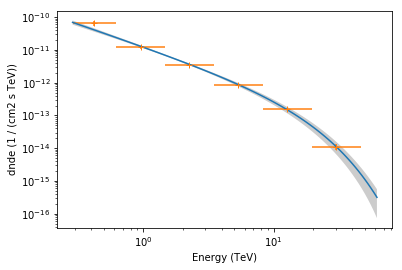

In [17]:
source.spectral_model().plot(source.energy_range)
source.spectral_model().plot_error(source.energy_range)
source.flux_points.plot()

In [18]:
source.components

[SourceCatalogObjectHGPSComponent('HGPSC 001'),
 SourceCatalogObjectHGPSComponent('HGPSC 002'),
 SourceCatalogObjectHGPSComponent('HGPSC 003')]

## Maps with Gammapy

This section shows you how to ... <TODO>

In [19]:
filename = os.path.join(hgps_data_path, 'hgps_map_significance_0.1deg_v1.fits.gz')
survey_map = Map.read(filename)
survey_map.get_by_coord((0, 0))

array([73.72828], dtype=float32)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x10c69d3c8>)

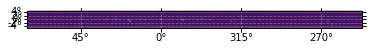

In [20]:
# TODO: show how to make a cutout and plot it
image = survey_map.crop(10)
image.plot()

In [21]:
# TODO: make model image and compare with data

## Conclusions

This concludes this tutorial how to access and work with the HGPS data from Python, using Astropy and Gammapy.

There are many things we didn't cover here. For example the [spectrum_models](http://docs.gammapy.org/dev/notebooks/spectrum_models.html) tutorial explains how to define a user-defined spectral model, e.g. you could call one of the astrophysical emission models from [Naima](http://naima.readthedocs.io/). The [sed_fitting_gammacat_fermi](http://docs.gammapy.org/dev/notebooks/sed_fitting_gammacat_fermi.html) tutorial shows how to access other catalog data (e.g. from Fermi-LAT or gamma-cat) and fit models to spectral points.


* If you have any questions about the HGPS data, please use the contact given at https://www.mpi-hd.mpg.de/hfm/HESS/hgps/ .
* If you have any questions or issues about Astropy or Gammapy, please use the Gammapy mailing list (see http://gammapy.org/contact.html).

**Please read the Appendix A of the paper to learn about the caveats to using the HGPS data. Especially note that the HGPS survey maps are correlated and thus no detailed source morphology analysis is possible, and also note the caveats concerning spectral models and spectral flux points.**